# 프로젝트: 작사가 만들기

### 루브릭 
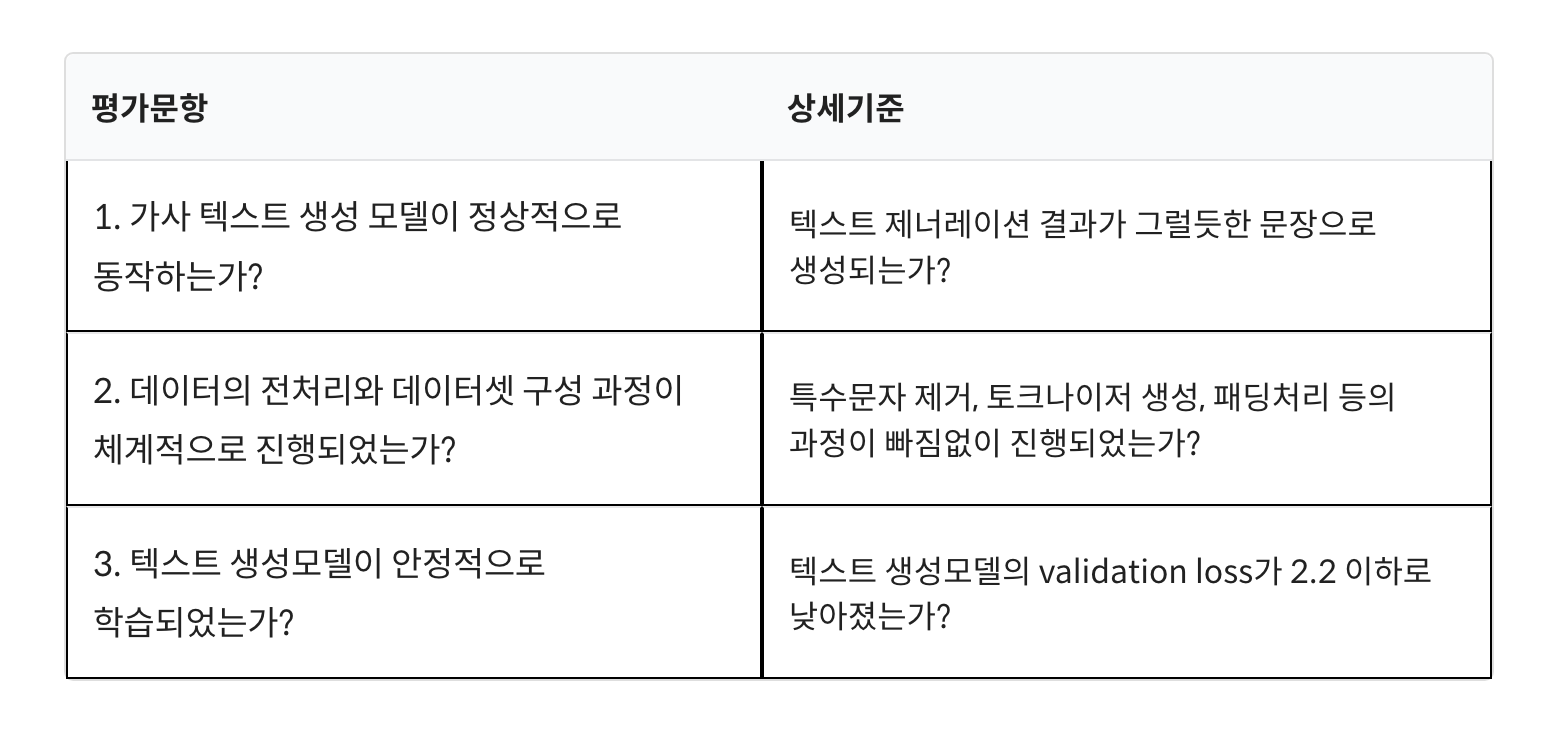

## - 데이터 읽어오기

In [54]:
#데이터 읽어오기
import os, re 
import numpy as np
import tensorflow as tf
import glob

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("Data size:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

Data size: 187088
Examples:
 ['[Verse 1]', 'They come from everywhere', 'A longing to be free']


## - 데이터 정제하기
- 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거한다.
- 너무 긴 문장은 작삭하기에 어울리지 않을 수도 있으므로 tokenized했을 때 토큰의 갯수가 15개 넘는 것은 제외한다.

In [55]:
#데이터 정제

for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0:
        continue
    if sentence[-1] == ":":
        continue
    if idx > 15: 
        break
    print(sentence)

[Verse 1]
They come from everywhere
A longing to be free
They come to join us here
From sea to shining sea And they all have a dream
As people always will
To be safe and warm
In that shining city on the hill Some wanna slam the door
Instead of opening the gate
Aw, let's turn this thing around
Before it gets too late [Chorus]
It's up to me and you
Love can conquer hate
I know this to be true
That's what makes us great [Verse 2]
Don't tell me a lie


In [56]:
#특수문자 제거

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()   
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) #특수문자 양쪽 공백
    sentence = re.sub(r'[" "]+', " ", sentence) #여러개의 공백은 하나의 공백으로.
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) #a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로.
    sentence = sentence.strip()#양쪽 공백 지우기
    sentence = '<start> ' + sentence + ' <end>'#<start>,<end>추가
    
    return sentence

In [57]:
corpus = []

for sentence in raw_corpus:#공백과 ':'제거
    if len(sentence) == 0: 
        continue
    if sentence[-1] == ":":
        continue
    
    corpus.append(preprocess_sentence(sentence))#특수문자제거

corpus[:10]#10개만 확인

['<start> verse <end>',
 '<start> they come from everywhere <end>',
 '<start> a longing to be free <end>',
 '<start> they come to join us here <end>',
 '<start> from sea to shining sea and they all have a dream <end>',
 '<start> as people always will <end>',
 '<start> to be safe and warm <end>',
 '<start> in that shining city on the hill some wanna slam the door <end>',
 '<start> instead of opening the gate <end>',
 '<start> aw , let s turn this thing around <end>']

- **Tokenize**

In [58]:
def tokenize(corpus):

    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, #전체 단어의 개수
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    total_data_text = list(tensor)
    num_tokens = [len(tokens) for tokens in total_data_text]
    max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)#corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰짐  
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=maxlen)
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2  520    3 ...    0    0    0]
 [   2   45   66 ...    0    0    0]
 [   2    9 3390 ...    0    0    0]
 ...
 [   2  561   21 ...    0    0    0]
 [   2  120   34 ...    0    0    0]
 [   2    5   22 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fa55843fe90>


In [59]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: 
        break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [60]:
src_input = tensor[:, :-1] #마지막 토큰 잘라냄. <pad>일 가능성이 높다.
tgt_input = tensor[:, 1:]#<start>잘라냄.

print(src_input[0])
print(tgt_input[0])

[  2 520   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]
[520   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]


## - 평가 데이터셋 분리하기

In [61]:

from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=34)

In [62]:
#데이터 쉡 확인
print('Source Train: ', enc_train.shape)
print('Target Train: ', dec_train.shape)


Source Train:  (140599, 19)
Target Train:  (140599, 19)


## - 모델 만들기

#### 목표)  
#### : 10epoch안에  target val_loss value 2.2 under


In [63]:
#텍스트 생성 모델 정의
class TextGenerator(tf.keras.Model):
    def __init__(self,vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)#단어를 추상적으로 변환하는 역할
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)#문장을 순차적으로 읽으며 단어 간의 연관성을 분석
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)#RNN통해 나온 단어를 결정
       
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 19 #언어의 백터화 (256은 너무 커서 19로 조정)
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [64]:
#모델학습

term = []
epochs = 7

optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)

term = model.fit(enc_train, 
          dec_train, 
          epochs=epochs,
          batch_size=256,
          validation_data=(enc_val, dec_val),
          verbose=1)

Epoch 1/7
550/550 [==============================] - 576s 1s/step - loss: 3.4444 - val_loss: 2.7176
Epoch 2/7
550/550 [==============================] - 557s 1s/step - loss: 2.6373 - val_loss: 2.4804
Epoch 3/7
550/550 [==============================] - 561s 1s/step - loss: 2.4318 - val_loss: 2.3530
Epoch 4/7
550/550 [==============================] - 561s 1s/step - loss: 2.2915 - val_loss: 2.2669
Epoch 5/7
550/550 [==============================] - 561s 1s/step - loss: 2.1881 - val_loss: 2.2052
Epoch 6/7
550/550 [==============================] - 561s 1s/step - loss: 2.0968 - val_loss: 2.1561
Epoch 7/7
550/550 [==============================] - 561s 1s/step - loss: 2.0051 - val_loss: 2.1072


In [67]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [68]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you to love me <end> '

-정리-
epoch 6 이상부터 val_loss가 2.2 이하로 떨어지기 시작했다.